# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [38]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# Suppress deprecation warning for GMM and LogNorm modules
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm


Load feature names.

In [39]:
feature_names = []
with open('../Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [40]:
X, Y = [], []

with open('../Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000L, 126L) (1124L, 126L)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

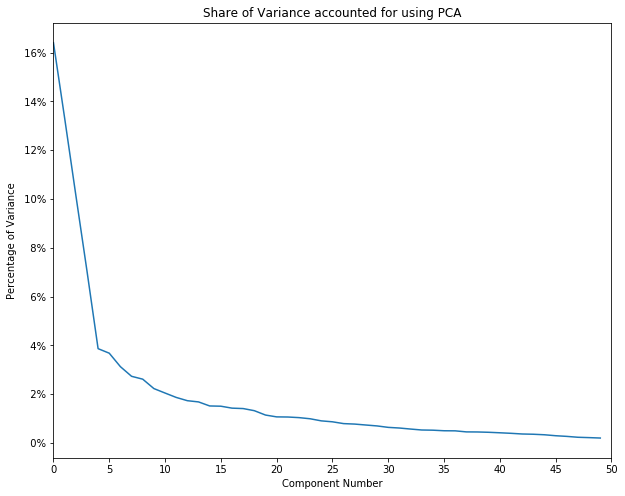

In [67]:
def P1():
### STUDENT START ###
    # Fit the training data using PCA
    pca_model = PCA()
    pca_model.fit(train_data)

    # Plot the share of variance for the first 50 components
    ax = pd.DataFrame(pca_model.explained_variance_ratio_[:50]).plot(
        title="Share of Variance accounted for using PCA",
        legend=False,
        figsize=(10, 8))
    # Set Axis labels and tick marks
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in ax.get_yticks()])
    ax.set_xticks([x for x in range(0,51)][::5])
    ax.set_xlabel("Component Number")
    ax.set_ylabel("Percentage of Variance")
### STUDENT END ###
P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

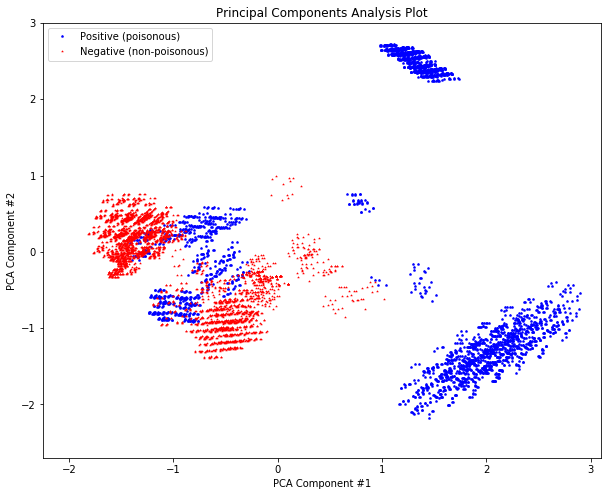

In [42]:
def P2():
### STUDENT START ###
    # Fit the training data using PCA and reduce to 2 dimensions
    pca_model = PCA(n_components=2)
    t_data_pca = pca_model.fit_transform(train_data)

    # Get Positive and negative x, y data
    pos_x, pos_y = (
        t_data_pca[:, 0][train_labels == 1],
        t_data_pca[:, 1][train_labels == 1])
    neg_x, neg_y = (
        t_data_pca[:, 0][train_labels == 0],
        t_data_pca[:, 1][train_labels == 0])

    # Plot transformed data
    plt.figure(figsize=(10, 8))
    plt.axis([-2.25, 3.1, -2.7, 3])

    # Positives
    plt.plot(
        pos_x, pos_y,
        'bp',
        markersize=3,
        markeredgewidth=0,
        label="Positive (poisonous)")

    # Negatives
    plt.plot(
        neg_x, neg_y,
        'r*',
        markersize=3,
        markeredgewidth=0,
        label="Negative (non-poisonous)")

    # Labels and legends
    plt.xlabel('PCA Component #1')
    plt.ylabel('PCA Component #2')
    plt.legend(frameon=True)
    plt.title('Principal Components Analysis Plot')
### STUDENT END ###
P2()


(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

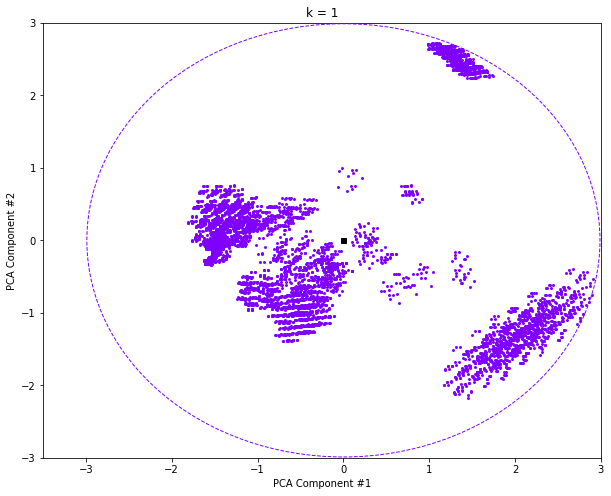

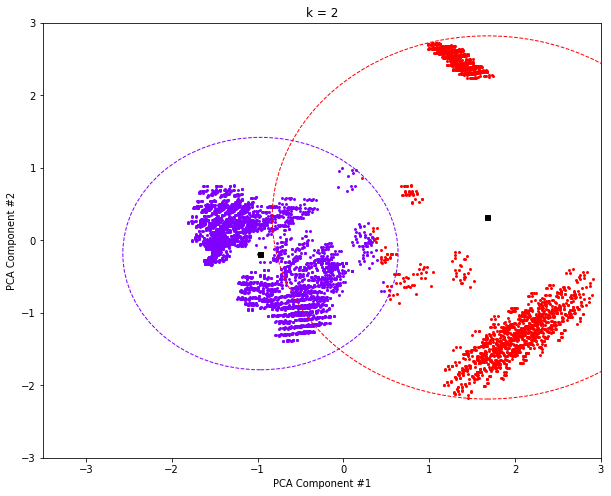

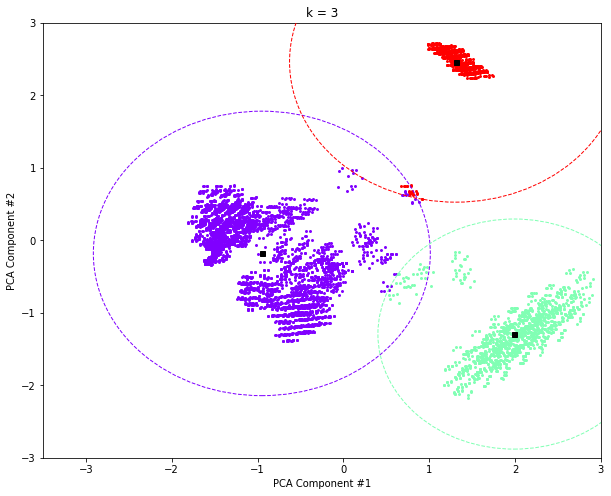

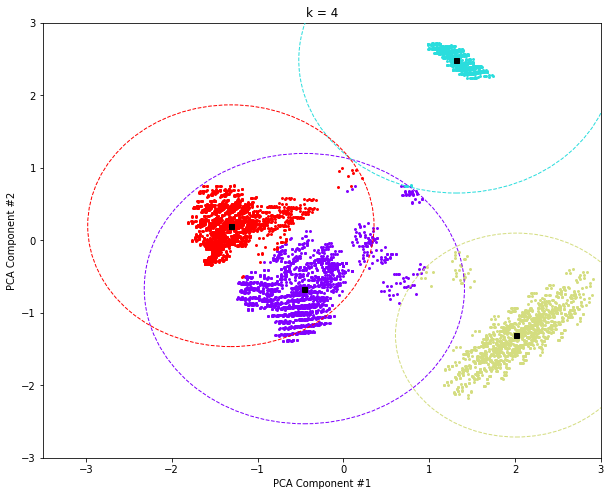

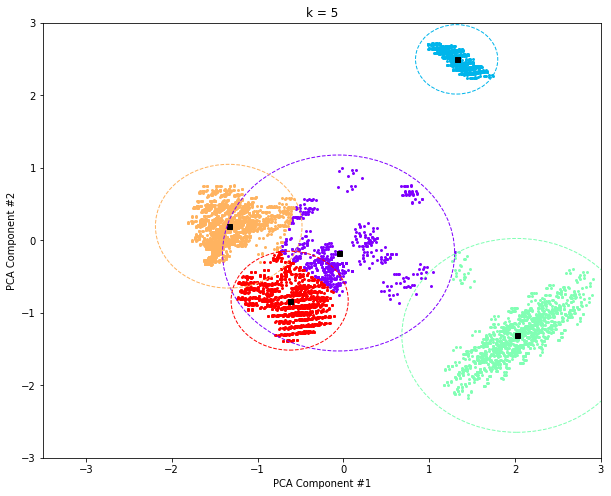

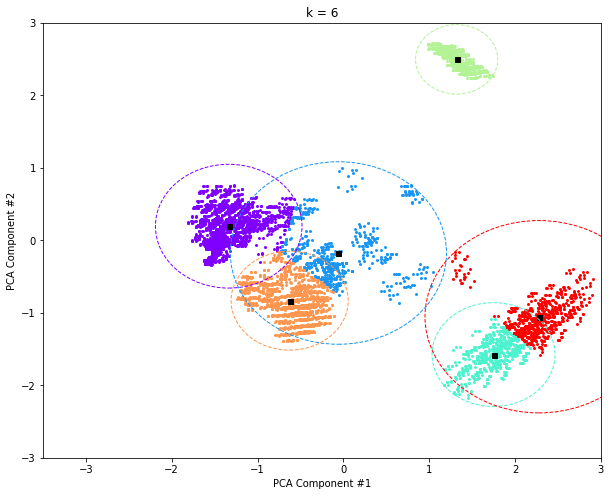

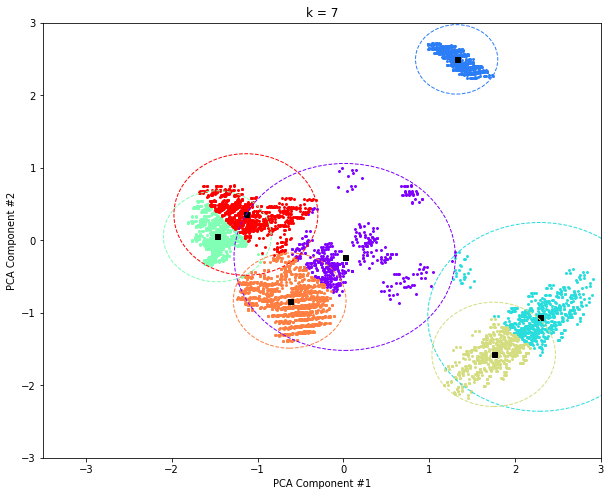

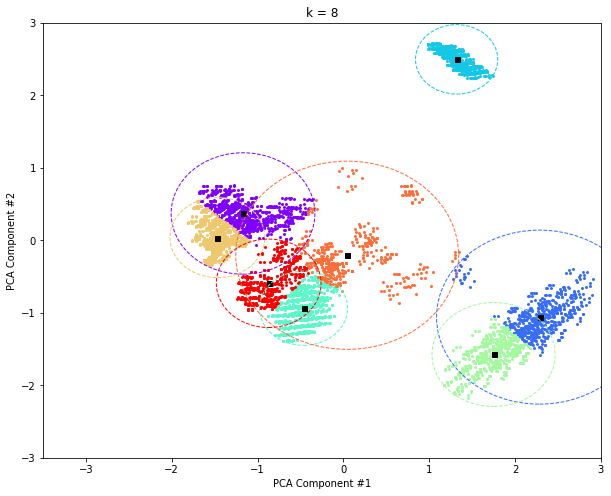

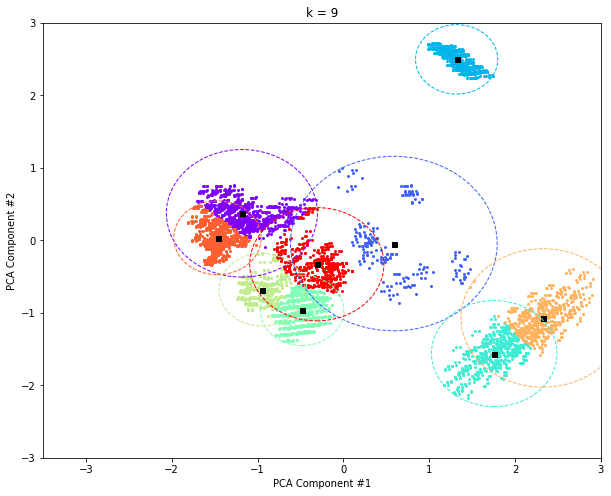

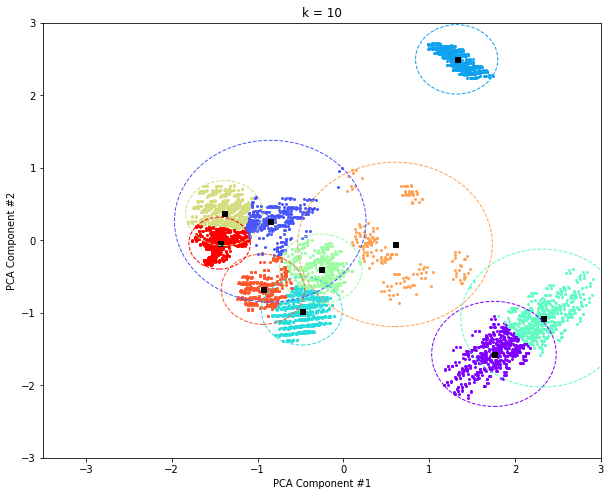

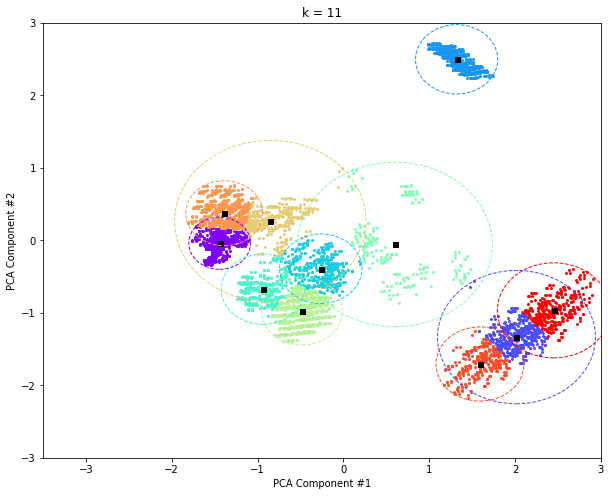

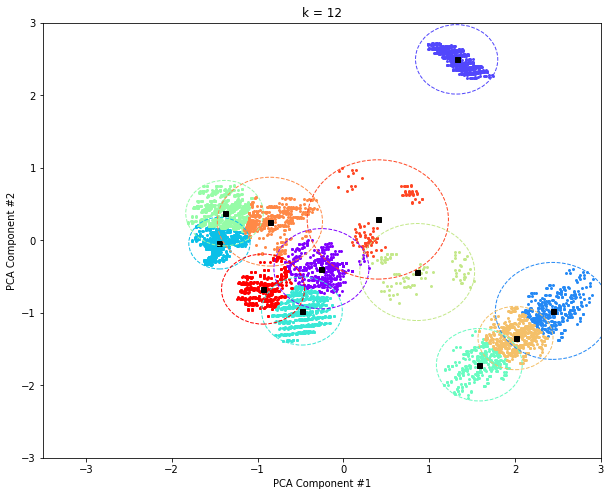

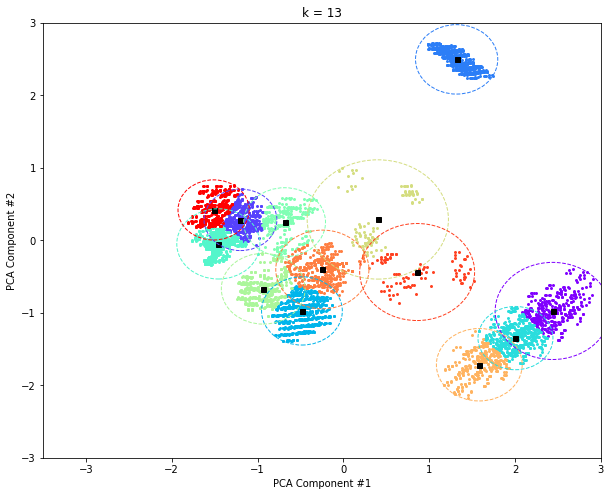

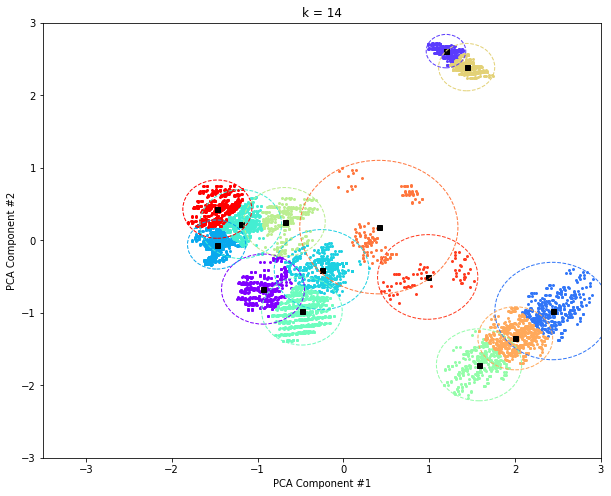

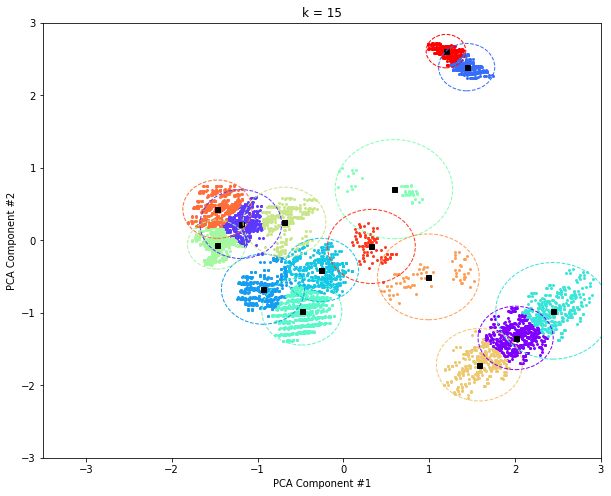

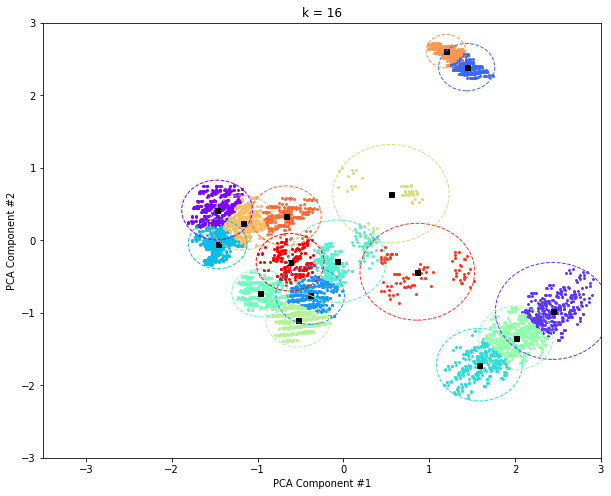

In [43]:
def P3():
### STUDENT START ###
    # Reduce train data to 2 dimensions
    pca_model = PCA(n_components=2)
    t_data_pca = pca_model.fit_transform(train_data)

    # Using colormap to color each cluster
    from matplotlib.pyplot import cm

    # Iterate over k-values (1 to 16 inclusive)
    for k in range(1, 17):
        # Fit K-means model using reduced dimension training data
        km_model = KMeans(n_clusters=k)
        km_model.fit(t_data_pca)

        # Distances of each data point to the centroids
        # Transform dimension training data to a cluster-distance space.
        clust_dists = km_model.transform(t_data_pca)

        # Set up plot
        plt.figure(figsize=(10, 8))
        plt.axis([-3.5, 3, -3, 3])

        # Create iterable to use for different cluster color values
        color = iter(cm.rainbow(np.linspace(
            0, 1, len(km_model.cluster_centers_))))

        # Iterate over each cluster center
        for i, center in enumerate(km_model.cluster_centers_):
            # Plot cluster points using a different color for each cluster
            cluster_k = km_model.labels_ == i
            c = next(color)
            plt.plot(
                t_data_pca[:, 0][cluster_k],
                t_data_pca[:, 1][cluster_k],
                color=c,
                ls='None',
                marker='o',
                markersize=3,
                markeredgewidth=0)

            # Plot cluster center (black square)
            plt.plot(center[0], center[1], 'ks', markersize=5)

            # Get the distance of the furthest point in the cluster
            # and plot a circle with a radius that intercepts it.
            furthest_point = np.amax(clust_dists[cluster_k][:, i])
            circle = plt.Circle(
                center,
                furthest_point,
                fill=False,
                ls='dashed',
                color=c)
            circle.set_zorder(99)  # Ensure circles are visible over data points
            plt.gca().add_artist(circle)

        # Labels and legends
        plt.xlabel('PCA Component #1')
        plt.ylabel('PCA Component #2')
        plt.title("k = " + str(k))
    del cm

### STUDENT END ###
P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

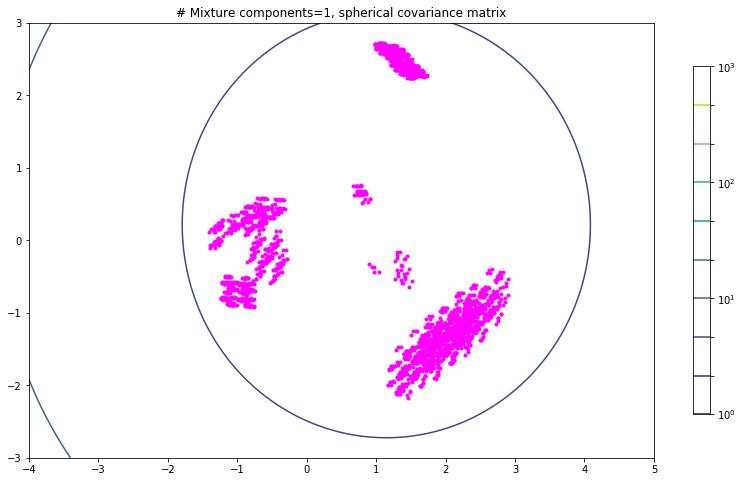

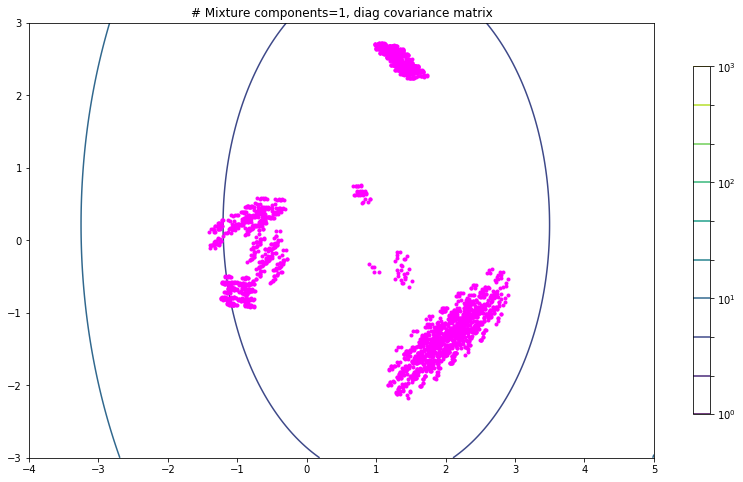

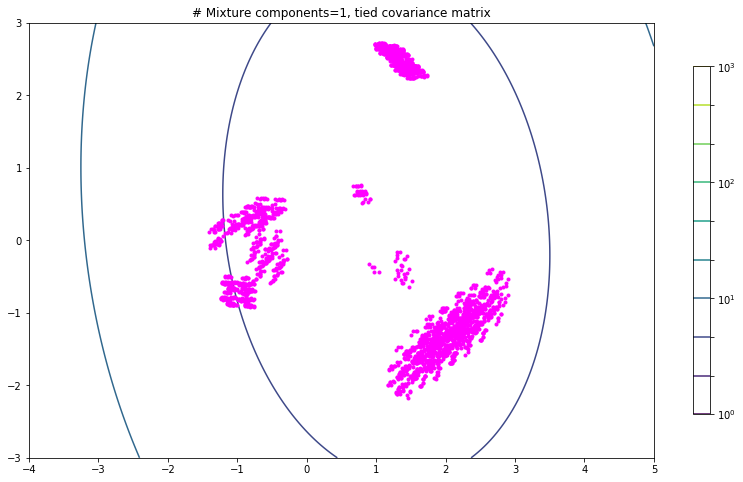

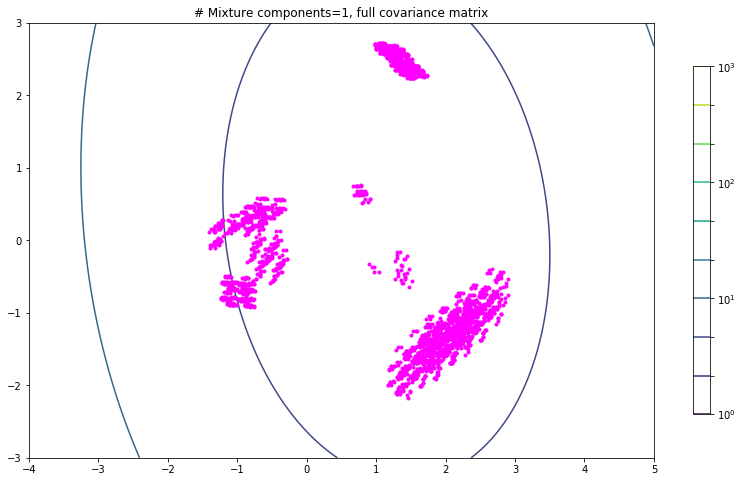

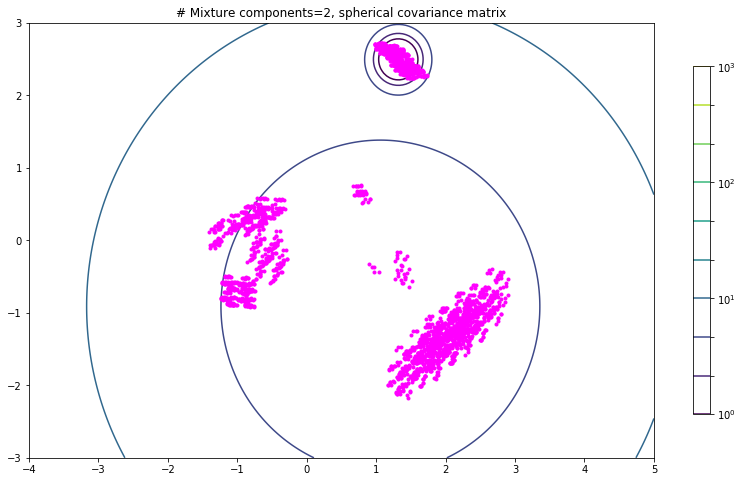

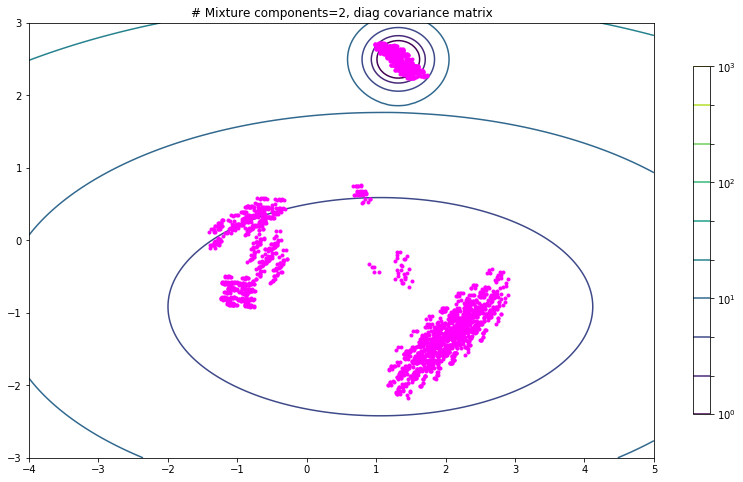

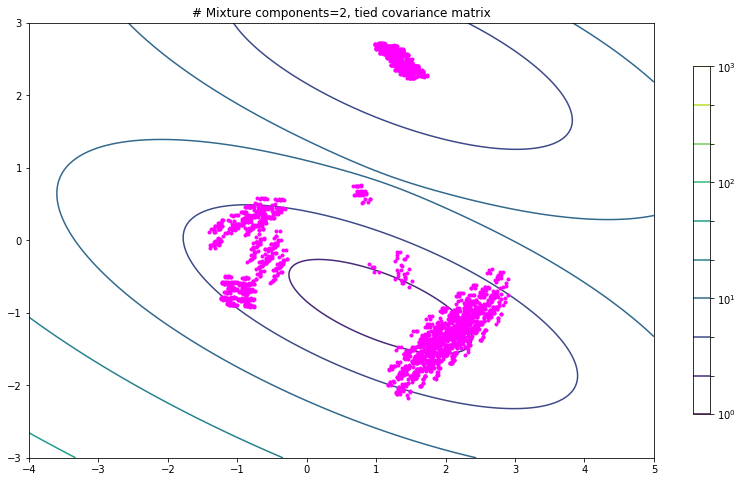

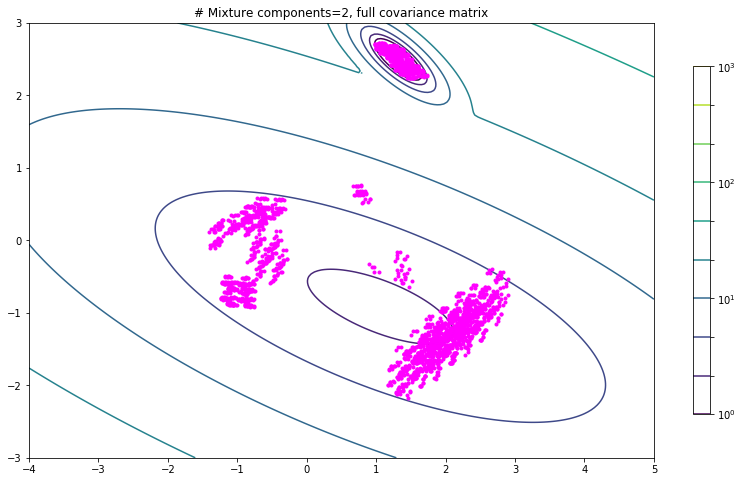

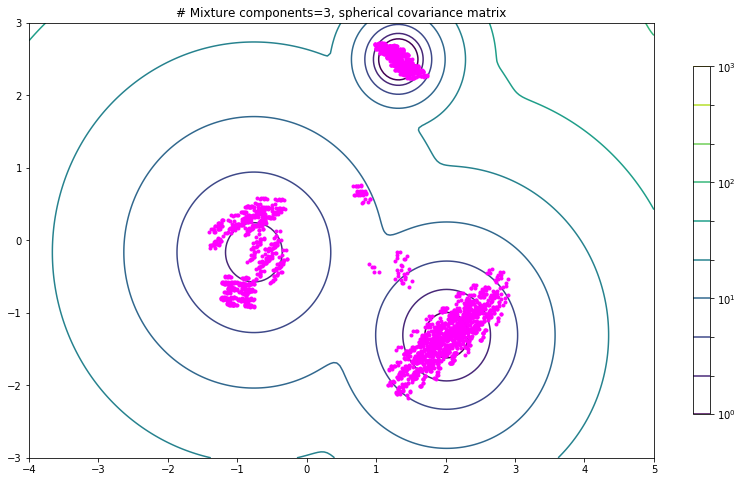

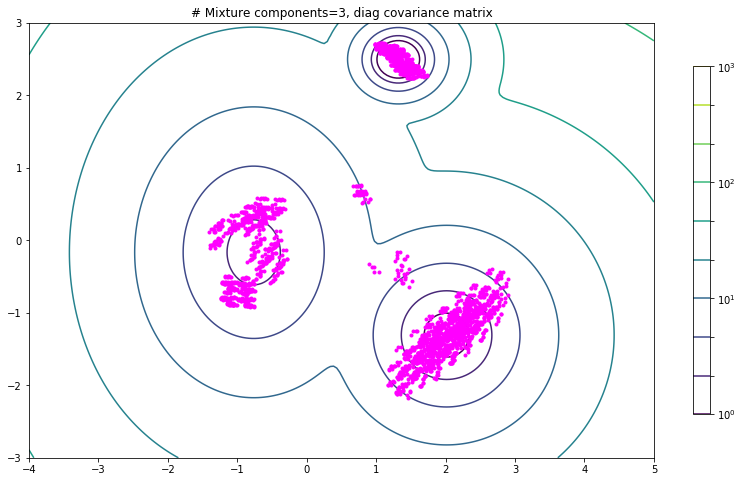

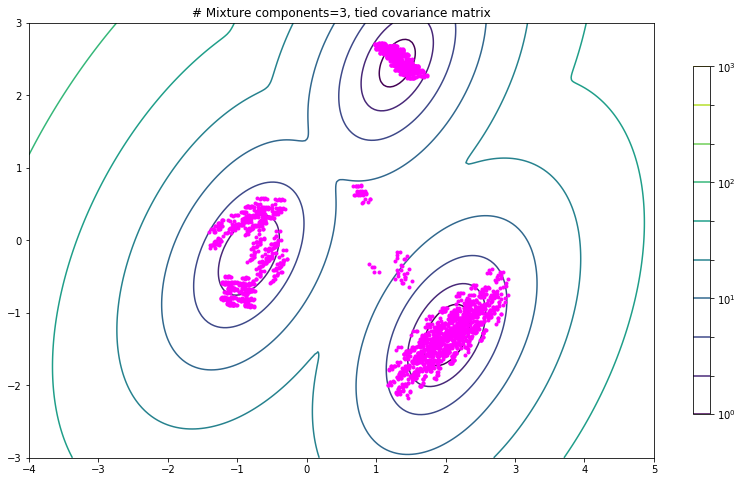

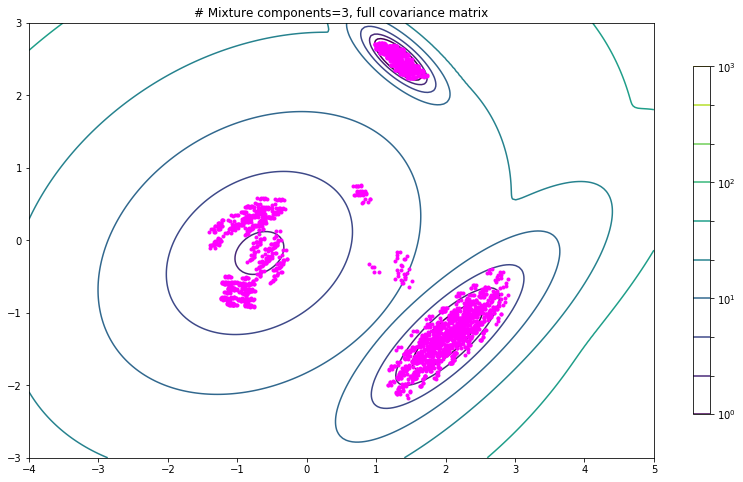

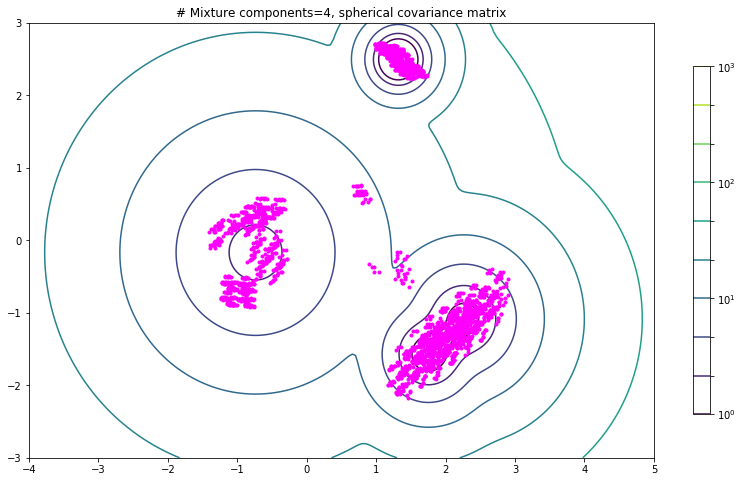

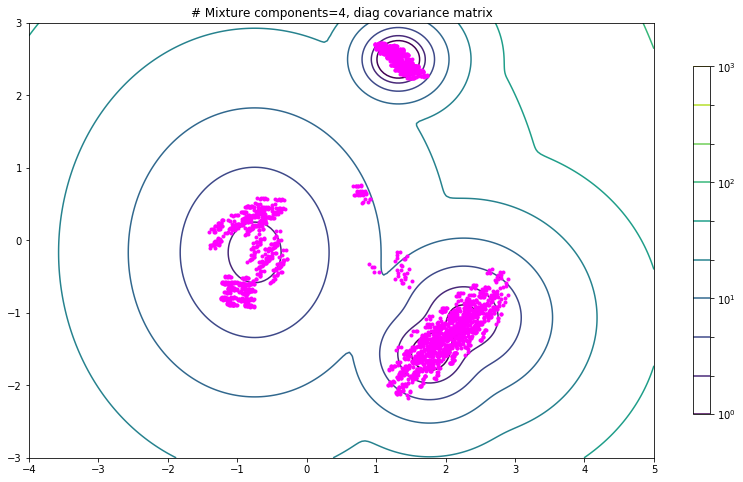

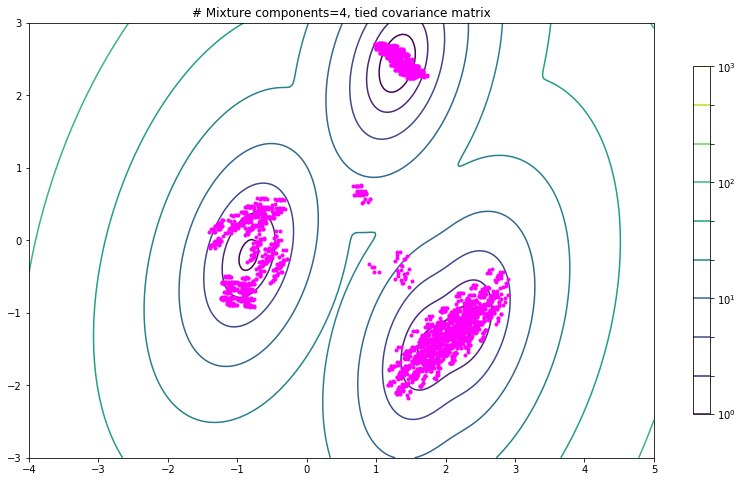

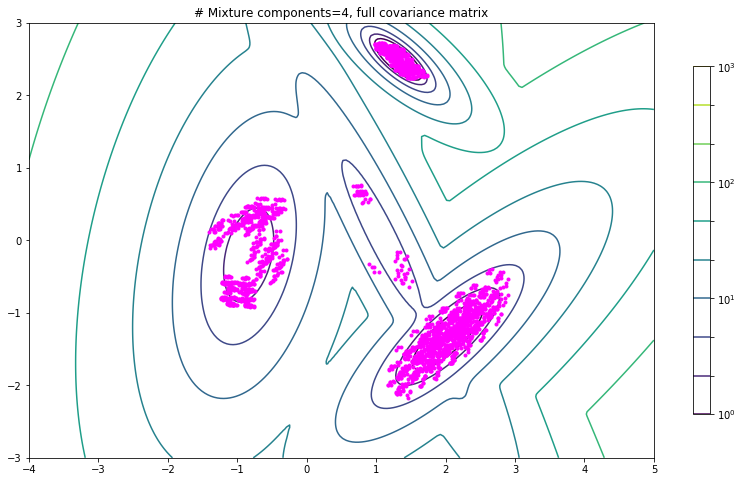

In [51]:

def P4():
### STUDENT START ###
    # Reduce train data to 2 dimensions
    pca_model = PCA(n_components=2)
    t_data_pca = pca_model.fit_transform(train_data)
    t_data_pca_pos = t_data_pca[train_labels == 1]  # Positive example data

    # Parameters to vary
    cov_types = ['spherical', 'diag', 'tied', 'full']

    # Fit and plot Gaussian mixture model with components from 1-4 using
    # the given covariance matrix types.
    for component in range(1, 5):
        for cov_index, cov_type in enumerate(cov_types):
            # Fit Gaussian mixture model
            gmm_model = GMM(
                n_components=component,
                covariance_type=cov_type)
            gmm_model.fit(t_data_pca_pos)

            # Generate contour lines
            x_min, x_max = (-4.0, 5.0)
            y_min, y_max = (-3.0, 3.0)
            n_points = 200
            X1, Y1 = np.meshgrid(
                np.linspace(x_min, x_max, n_points),
                np.linspace(y_min, y_max, n_points))
            XX = np.array([X1.ravel(), Y1.ravel()]).T
            Z = -gmm_model.score_samples(XX)[0]
            Z = Z.reshape(X1.shape)
            plt.figure(figsize=(14, 8))
            plt.axis([x_min, x_max, y_min, y_max])
            CS = plt.contour(
                X1, Y1, Z,
                norm=LogNorm(
                    vmin=1.0, vmax=1000.0),
                levels=np.logspace(0, 3, 10))
            CB = plt.colorbar(
                CS, shrink=0.8, extend='both')

            # Plot Training data
            plt.plot(
                t_data_pca_pos[:, 0],
                t_data_pca_pos[:, 1],
                color="magenta",
                ls='None',
                marker='o',
                markersize=3)
            plt.title(
                '# Mixture components=%s, %s covariance matrix' %
                (str(component), cov_type))

### STUDENT END ###
P4()


(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [68]:
def P5():
### STUDENT START ###
    # Reduce both train and test data to 2 dimensions
    # Note that test data is transformed using the PCA
    # generated from training data
    pca_model = PCA(n_components=2)
    train_data_pca = pca_model.fit_transform(train_data)
    test_data_pca = pca_model.transform(test_data)

    # Get positive and negative labeled training data
    pos_train_data = train_data_pca[train_labels == 1]
    neg_train_data = train_data_pca[train_labels == 0]

    # Fit Gaussian mixture model and use it to get probabilities
    # for positives and negatives in test data
    gmm_model = GMM(n_components=4, covariance_type='full')
    gmm_model.fit(pos_train_data)
    probs_pos = gmm_model.score(test_data_pca)
    gmm_model.fit(neg_train_data)
    probs_neg = gmm_model.score(test_data_pca)

    # Calculate prediction and accuracy
    # Each element is True / False if positive / negative is predicted
    predictions = probs_pos > probs_neg
    # Each element is True / False if predictions were accurate or not
    accurate_predictions = np.equal(predictions.astype(int), test_labels)
    accuracy = 100.0 * sum(accurate_predictions) / len(test_labels)
    print "The Gaussian mixture model method yielded a prediction accuracy " \
        "of {:.2f}%.".format(accuracy)
### STUDENT END ###
P5()


The Gaussian mixture model method yielded a prediction accuracy of 95.11%.


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [72]:

def P6():
### STUDENT START ###
    # Skip further analysis if number of parameters exceeds this value
    max_params = 50

    # Results data frame
    df_tested = pd.DataFrame(
        columns=[
            "pca_components",
            "cov_type",
            "gmm_components",
            "num_params",
            "accuracy"])

    # Vary number of PCA components, GMM components, covariance type and record
    # the result
    for pca_components in range(1, 51):
        for cov_type in ['spherical', 'tied', 'diag', 'full']:
            for gmm_components in range(1, 51):
                # Determine the number of parameters from the covariance matrix
                # type
                if cov_type is 'spherical' or cov_type is 'diag':
                    cov_components = pca_components
                elif cov_type is 'tied':
                    cov_components = 1.0 * (pca_components*(pca_components+1)) / 2
                elif cov_type is 'full':
                    cov_components = pca_components**2

                # Get total number of parameters
                num_params = (
                    (pca_components + cov_components)
                    * gmm_components * 2)

                # Skip tests with too many parameters
                if num_params > max_params:
                    pass
                else:
                    # Reduce both train and test data to 2 dimensions
                    # Note that test data is transformed using the PCA
                    # generated from training data
                    pca_model = PCA(n_components=pca_components)
                    train_data_pca = pca_model.fit_transform(train_data)
                    test_data_pca = pca_model.transform(test_data)

                    # Get positive and negative labeled training data
                    pos_train_data = train_data_pca[train_labels == 1]
                    neg_train_data = train_data_pca[train_labels == 0]

                    # Fit Gaussian mixture model and use it to get probabilities
                    # for positives and negatives in test data
                    gmm_model = GMM(
                        n_components=gmm_components,
                        covariance_type=cov_type)
                    gmm_model.fit(pos_train_data)
                    probs_pos = gmm_model.score(test_data_pca)
                    gmm_model.fit(neg_train_data)
                    probs_neg = gmm_model.score(test_data_pca)

                    # Calculate prediction and accuracy
                    # Each element is True / False if positive or negative is
                    # predicted
                    predictions = probs_pos > probs_neg
                    # Each element is True / False if predictions were accurate
                    # or not
                    accurate_predictions = np.equal(
                        predictions.astype(int), test_labels)
                    accuracy = 1.0 * sum(accurate_predictions) / len(test_labels)

                    # Store test result
                    df_tested = df_tested.append({
                        "pca_components": pca_components,
                        "cov_type": cov_type,
                        "gmm_components": gmm_components,
                        "num_params": num_params,
                        "accuracy": accuracy}, ignore_index=True)
    # Print results
    from IPython.display import display
    print display(df_tested.sort_values(
        by=['accuracy', 'cov_type'],
        ascending=False))
    print
    max_accuracy = df_tested['accuracy'].max()
    max_acc_row = df_tested[df_tested['accuracy'] == max_accuracy]
    print "The maximum accuracy achieved was {:3.2f}%, using {} PCA components"\
        ", a {} covariance matrix, and {} GMM components.".format(
            100.0 * max_accuracy,
            max_acc_row['pca_components'].values[0],
            max_acc_row['cov_type'].values[0],
            max_acc_row['gmm_components'].values[0])

### STUDENT END ###
P6()


,pca_components,cov_type,gmm_components,num_params,accuracy
72,3,spherical,4,48,0.959075
68,2,full,4,48,0.951068
63,2,diag,5,40,0.951068
64,2,diag,6,48,0.950178
56,2,tied,3,30,0.946619
51,2,spherical,4,32,0.946619
61,2,diag,3,24,0.946619
91,5,tied,1,40,0.945730
50,2,spherical,3,24,0.945730
53,2,spherical,6,48,0.945730


None

The maximum accuracy achieved was 95.91%, using 3 PCA components, a spherical covariance matrix, and 4 GMM components.
